In [1]:
!pip install yfinance
!pip install yahooquery
!pip install tvdatafeed
!pip install tensorflow
!pip install mplfinance
!pip install cairocffi
from tvDatafeed import TvDatafeed, Interval
from yahooquery import Screener
import yfinance as yf   
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import random 
from tensorflow.keras.models import load_model
import os
import shutil
import mplfinance as mpl 
from datetime import datetime
import glob
from PIL import Image
import cv2
%matplotlib notebook
import gc
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('agg')
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,AveragePooling2D,GlobalAveragePooling2D
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 981 kB 31.4 MB/s 
     |████████████████████████████████| 358 kB 69.3 MB/s 
     |████████████████████████████████| 139 kB 70.3 MB/s 
     |████████████████████████████████| 4.1 MB 61.3 MB/s 
     |████████████████████████████████| 55 kB 5.1 MB/s 
     |████████████████████████████████| 58 kB 7.6 MB/s 
  Attempting uninstall: urll

In [2]:
def work_with_dir():
  if os.path.exists("/content/data/"):
    shutil.rmtree("/content/data/", ignore_errors=True)
    print("Data Folder Removed")
    os.mkdir("/content/data/")
  if not os.path.exists("/content/data/"):
    os.mkdir("/content/data/")
  if not os.path.exists("/content/extracted/"):
    os.mkdir("/content/extracted/")
  if not os.path.exists("/content/checkpoints/"):
    os.mkdir("/content/checkpoints/")
def get_crypto_syms():
   screens = [
       'all_cryptocurrencies_us', 'all_cryptocurrencies_au', 'all_cryptocurrencies_ca', 'all_cryptocurrencies_eu', 'all_cryptocurrencies_gb', 'all_cryptocurrencies_in', ]
   s = Screener()
   symbols = []
   for i in screens:
      data = s.get_screeners(i, count=250)
      dicts = data[i]['quotes']
      syms = [d['symbol'] for d in dicts]
      for sym in syms:
        symbols.append(sym)
   return symbols
def download_data(symbols, periodd, intervall):
  indexx = 100
  work_with_dir()
  for symbol in symbols:
    if ((symbols.index(symbol)+1) % 100 == 0):
      print(f" -- {indexx}", end="")
      indexx = indexx + 100
    try:
        data = yf.download(symbol, period=periodd,
                           interval=intervall, progress=False, show_errors=False)
        if data.empty:
           pass
        else:
            data.to_csv(f"/content/data/{symbol}.csv")
    except:
       print("Error!")
  print(" ")
def extract_data(how_many_future_candles, how_many_past_candles, each_row_past):
  print(f"Files In Data : {len(os.listdir('/content/data/'))}")
  pd.options.mode.chained_assignment = None
  files = os.listdir("/content/data/")
  print("Processing File:")
  now = datetime.now().strftime("%H%M%S")
  os.mkdir(f"/content/extracted/{now}/")
  index = 1
  for file in files:
     print(f"File Number {index}:", end=" ")
     each_file_proc(file, now, how_many_future_candles,
                    how_many_past_candles, each_row_past)
     index = index + 1
  print(" ")
  return now
def each_file_proc(file, now, how_many_future_candles, how_many_past_candles, each_row_past):
    address = f"/content/data/{file}"
    data = pd.read_csv(address)
    if len(data.columns) == 7:
      data = data.iloc[:, 1:]
    data = np.array(data)
    data = data.astype(float)
    max_index = data.shape[0]-which_future_or_past
    for i in range(each_row_past,max_index):
        rows = data[i-each_row_past:i, :]

        next_candles = []
        for z in range(0, how_many_future_candles):
          next_candles.append(data[i+z][3]-data[i+z][0])
        next_candles = sum(next_candles)
        if next_candles > 0:
          sugg = 1
        else:
          sugg = 0

        df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close","Adj Close","Volume"])

        df.index.name = "Date"

        df.index = pd.to_datetime(df.index)
        right_now = datetime.now().strftime("%H%M%S%f")
        address = f"/content/extracted/{now}/{right_now}_{sugg}.png"
        

        fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
        
        fig.savefig(address)
        fig.clf()

        if i % 10 == 0:
            print(f"{i}/{max_index}", end=" ")
        if i % 20:
          plt.close("all")
        if i % 270 ==0:
          print("")
    plt.close("all")
    print("")

def start(how_many_future_candles, how_many_past_candles, each_row_past):
    folder_name = extract_data(
        how_many_future_candles, how_many_past_candles, each_row_past)
    return folder_name

In [3]:
symbols = get_crypto_syms()
print(f"Symbols : {len(symbols)}")
symbols = ["btc-usd","eth-usd","trx-usd","ltc-usd","xrp-usd","bnb-usd"]
download_data(symbols[:100],"50d","1h")

Symbols : 1500
 


In [ ]:
how_many_future_candles = 25
how_many_past_candles = 1
each_row_past = 90


global which_future_or_past
which_future_or_past = None
if how_many_future_candles > how_many_past_candles:
    which_future_or_past = how_many_future_candles
else:
    which_future_or_past = how_many_past_candles
folder_name = start(how_many_future_candles,how_many_past_candles,each_row_past)
len(os.listdir(f"/content/extracted/{folder_name}"))

Files In Data : 6
Processing File:
File Number 1: 90/1171 100/1171 110/1171 120/1171 130/1171 140/1171 150/1171 160/1171 170/1171 180/1171 190/1171 200/1171 210/1171 220/1171 230/1171 240/1171 250/1171 260/1171 270/1171 
280/1171 290/1171 300/1171 310/1171 320/1171 330/1171 340/1171 350/1171 360/1171 370/1171 380/1171 390/1171 400/1171 410/1171 420/1171 430/1171 440/1171 450/1171 460/1171 470/1171 480/1171 490/1171 500/1171 510/1171 520/1171 530/1171 540/1171 
550/1171 560/1171 570/1171 580/1171 590/1171 600/1171 610/1171 620/1171 630/1171 640/1171 650/1171 660/1171 670/1171 680/1171 690/1171 700/1171 710/1171 720/1171 730/1171 740/1171 750/1171 760/1171 770/1171 780/1171 790/1171 800/1171 810/1171 
820/1171 830/1171 840/1171 850/1171 860/1171 870/1171 880/1171 890/1171 900/1171 910/1171 920/1171 930/1171 940/1171 950/1171 960/1171 970/1171 980/1171 990/1171 1000/1171 1010/1171 1020/1171 1030/1171 1040/1171 1050/1171 1060/1171 1070/1171 1080/1171 
1090/1171 1100/1171 1110/1171 1120/117

In [ ]:
#folder_name = "162812"

shutil.make_archive(folder_name,"zip",f"/content/extracted/{folder_name}/")
#shutil.unpack_archive(f"/content/{folder_name}.zip",f"/content/extracted/{folder_name}")
label = []
data  = []
files = os.listdir(f"/content/extracted/{folder_name}/")
for i, image_name in enumerate(files):
  if image_name.split(".")[1] == "png":
    image = cv2.imread(f"/content/extracted/{folder_name}"+"/"+image_name,0)
    dim = (150, 150)
    resized = cv2.resize(image, dim)
    data.append(np.array(resized))
    sugg = image_name.split("_")[1].split(".")[0]
    label.append(int(sugg))
data = np.array(data)
data = data / 255
print(data.shape)
xTrain , xTest , yTrain , yTest = train_test_split(data,label,test_size=0.2,random_state=99)
data = None
label = None
print(f"xTrain : {len(xTrain)} \\ xTest : {len(xTest)}")
nytrain = []
nytest = []
yn = 0
nn = 0
for i in yTrain:
  if i == 1:
    nytrain.append([1,0])
    yn += 1
  else:
    nytrain.append([0,1])
    nn += 1
for i in yTest:
  if i == 1:
    nytest.append([1,0])
    yn += 1
  else:
    nytest.append([0,1])
    nn += 1
yTrain = np.array(nytrain)
yTest = np.array(nytest)
print(f"yn: {yn} nn: {nn}")

In [ ]:
model.evaluate(xTest,yTest)

8/8 [==============================] - 0s 34ms/step - loss: 2.8857 - accuracy: 0.4956


[2.885654926300049, 0.4955752193927765]

In [19]:
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(128,    (3,3),activation="relu", input_shape=(xTrain.shape[1], xTrain.shape[2],1), kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128,    (3,3),activation="relu", kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005))) 
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(128,     (3,3),activation="relu", kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005)))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(64,     (2,2),activation="relu", kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005)))
model.add(Flatten())
model.add(Dense(750,activation="relu", kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005)))
model.add(Dropout(0.1))
model.add(Dense(750,activation="relu", kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005)))
model.add(Dropout(0.1))
model.add(Dense(750,activation="relu", kernel_regularizer=l2(0.00005), bias_regularizer=l2(0.00005)))
model.add(Dense(2,activation="sigmoid"))

adamax = tf.keras.optimizers.Adamax(
    learning_rate=0.00015)
model.compile(loss='categorical_crossentropy',
              optimizer=adamax,
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 128)     1280      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 128)      0         
 2D)                                                             
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 128)       147584    
                                                                 
 average_pooling2d_12 (Avera  (None, 36, 36, 128)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 128)       147584    
                                                                 
 average_pooling2d_13 (Avera  (None, 17, 17, 128)     

In [20]:
filepath = "/content/checkpoints/{epoch:02d}-{val_accuracy:.2f}.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#model.fit(xTrain,yTrain,batch_size=64,epochs=30,validation_data=(xTest,yTest), callbacks=model_checkpoint_callback)
model.fit(xTrain,yTrain,batch_size=32,epochs=20,validation_data=(xTest,yTest))

Epoch 1/20
163/163 [==============================] - 13s 75ms/step - loss: 0.8059 - accuracy: 0.5202 - val_loss: 0.7827 - val_accuracy: 0.5193
Epoch 2/20
163/163 [==============================] - 12s 73ms/step - loss: 0.7483 - accuracy: 0.5921 - val_loss: 0.7214 - val_accuracy: 0.6117
Epoch 3/20
163/163 [==============================] - 12s 73ms/step - loss: 0.6737 - accuracy: 0.6766 - val_loss: 0.6313 - val_accuracy: 0.7257
Epoch 4/20
163/163 [==============================] - 12s 74ms/step - loss: 0.5827 - accuracy: 0.7519 - val_loss: 0.5455 - val_accuracy: 0.7820
Epoch 5/20
163/163 [==============================] - 12s 73ms/step - loss: 0.4821 - accuracy: 0.8152 - val_loss: 0.4796 - val_accuracy: 0.8159
Epoch 6/20
163/163 [==============================] - 12s 73ms/step - loss: 0.3930 - accuracy: 0.8666 - val_loss: 0.5200 - val_accuracy: 0.8020
Epoch 7/20
163/163 [==============================] - 12s 73ms/step - loss: 0.3340 - accuracy: 0.8924 - val_loss: 0.3662 - val_accuracy:

In [ ]:
model.save(f"1.h5")

[*********************100%***********************]  1 of 1 completed
                                   Open          High           Low  \
2022-07-23 00:00:00+00:00  22701.097656  22784.156250  22633.107422   
2022-07-23 01:00:00+00:00  22769.445312  22835.929688  22769.445312   
2022-07-23 02:00:00+00:00  22789.802734  22885.261719  22789.802734   
2022-07-23 03:00:00+00:00  22840.515625  22887.355469  22830.691406   
2022-07-23 04:00:00+00:00  22833.572266  22962.953125  22770.201172   
...                                 ...           ...           ...   
2022-08-01 17:00:00+00:00  23199.355469  23199.355469  22942.851562   
2022-08-01 18:00:00+00:00  22971.015625  22992.982422  22890.796875   
2022-08-01 19:00:00+00:00  22962.234375  23012.230469  22936.394531   
2022-08-01 20:00:00+00:00  22963.669922  22973.173828  22963.669922   
2022-08-01 20:07:00+00:00  22974.019531  22974.019531  22974.019531   

                                  Close     Adj Close      Volume  
2022-07-23

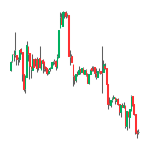

In [ ]:
symbol,period,interval="btc-usd","10d","1h"
data = yf.download(tickers=symbol,period=period,interval=interval)
print(data)
data = np.array(data)
data = data.astype(float)
i = -1
rows = data[i-each_row_past:i, :]
df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close","Adj Close","Volume"])
df.index.name = "Date"
df.index = pd.to_datetime(df.index)
fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
fig.savefig("picture.png")

In [ ]:
image = cv2.imread("/content/picture.png",0)
dim = (128, 128)
resized = cv2.resize(image, dim)
data = np.array(resized)
model.predict([[data.reshape(1,128,128,1)]])

array([[1., 0.]], dtype=float32)

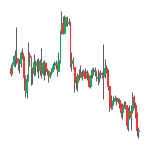

In [ ]:
tv = TvDatafeed()
data = tv.get_hist(symbol="btcusdt",exchange="binance",interval=Interval.in_1_hour,n_bars=1000)
data = np.array(data)
i = -1
rows = data[i-each_row_past:i, 1:5]
rows.shape
df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close"])
df.index.name = "Date"
df.index = pd.to_datetime(df.index)
df = df.apply(lambda col:pd.to_numeric(col, errors='coerce'))
fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
fig.savefig("picture1.png")

In [ ]:
image = cv2.imread("/content/picture1.png",0)
dim = (128, 128)
resized = cv2.resize(image, dim)
data = np.array(resized)
model.predict([[data.reshape(1,128,128,1)]])

array([[1., 0.]], dtype=float32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
lst = []
while True:
  ans = input()
  if ans == "exit":
    break
  lst.append(int(ans))
print(sum(max),len(lst))